# Convenience Tools

When computing CPD's, it may be of interest to plot the graph of the error evolution, or the gradients, etc, as we've made in the previous example. The display options also helps in showing information during and after the computations, but as we saw in the lesson about outputs, there are a lot of information remain to be seen. In order to facilitate the user's life I created a function which does what I always want to see after the computations: the most relevant informations and a plot just before.  

# Foxit

The function *foxit* does the job for you. It will run the CPD with the requested options, print more information then the CPD itself, and then make a nice plot. Let's see how it works. 

In [1]:
import numpy as np
import TensorFox as tfx

In [2]:
# Load the swimmer tensor again. 
T = np.load('swimmer.npy')
m, n, p = T.shape
Tsize = np.linalg.norm(T)

Final results
    Number of steps = 169
    Relative error = 9.765843973799419e-05
    Accuracy =  99.99023 %


Parameters used
    maximum of iterations: 200
    tolerance: 1e-12
    initialization: random
    algorithm: conjugate gradient (dynamic)



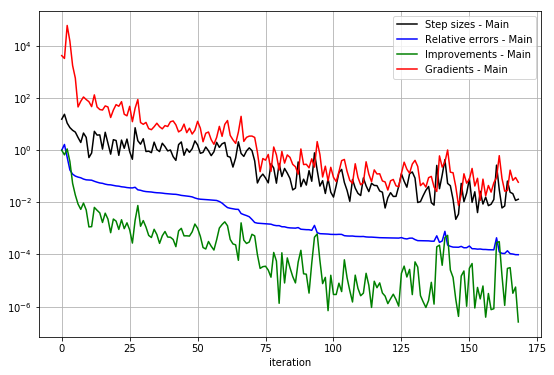

In [3]:
r = 50
factors, T_approx, output = tfx.foxit(T, r)

This is not the only convenience we need. Besides computing the CPD and showing the results in a nice format, we need to be practical too. The whole point of computing CPD's is to obtain good approximations. Sometimes (maybe a lot) the first computation is not precise enough and we need to try again. Of course this is just a matter of writing a loop and keeping the best results. But if this have to be done, why not just incorporate it to Tensor Fox already. That is one more convenience that the function *foxit* brings to the table. The key word *bestof* tells the program to run a certain number of CPD's and keep only the best one. Let's give it a try with more iterations this time.

Final results
    Number of steps = 202
    Relative error = 0.011638230492317185
    Accuracy =  98.83618 %


Parameters used
    maximum of iterations: 400
    tolerance: 1e-12
    initialization: random
    algorithm: conjugate gradient (dynamic)



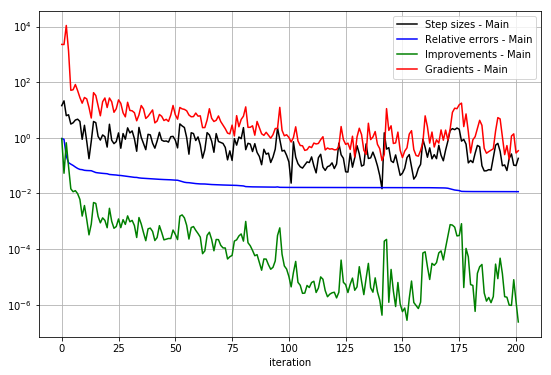

In [4]:
class options:
    maxiter = 400

factors, T_approx, output = tfx.foxit(T, r, options, bestof=10)

# Testing Models

Tensor Fox has a lot of options, and discovering which combination is the best for a certain kind of problem is a hard task. This can be even worse if we are dealing not with a specific tensor, but with a set of tensors, maybe a parametrized family of tensors. Again, we can code a nested loop over the models, and check the model performance with all the tensors. The results could be displayed on a table, we could make plots, and so on. This kind of hyperparameter grid search is common, so I included a special routine in Tensor Fox to facilitate this job for you.

Suppose you have $N$ tensors $T_i$, for $i=1 \ldots N$, each one with its own rank $r_i$. Additionally, suppose we know thresholds errors associated to each tensor, that is, given a tensor $T_i$ we know (or we guess) a (relative) error $\varepsilon_i > 0$ such that an approximation $T_{approx}$ is 'good' if 

$$\frac{\|T_i - T_{approx}\|}{\|T_i\|} < \varepsilon_i,$$
otherwise the approximation is labelled as 'bad'.

Now let $M_i$ be a model to be tested. In our context a model is a choice of parameters for the class 'options'. We can compute several CPD's with this model for the tensor $T_i$. By counting how many successes and failures the model obtained we are able to measure how good is the model. This is the general idea, and this idea is implemented in the function 'test_tensors'. This function also handles tensors with noise. If two tensors are passed to the function, the first is considered to be the original and second one is the noisy. The CPD is then computed with respect to the second tensor, and the error of the approximation is computed with respect to the first tensor.

## How to use this function 

Now we are familiar with the procedure, let's begin to marking things more concrete. The function 'test_tensors' receives 4 arguments which we describe below, in order.

 - The first one is a list with $N$ tuples. Each tuple is of the form (name, T, r, thr), where 'name' is a string with a name for the tensor, T is the tensor itself, r is the rank, and thr and a threshold value. In the case of tensor of noise, the tuple has the form (name, T, T_noise, r, thr).
 
 - The second argument is a list with $N$ classes. Each class is a class of options with the Tensor Fox format. The ith class of this list will be tested against the ith tensor of the previous list, using the prescribed rank and threshold error.
 
 - The third argument is the number of times we will compute a CPD for the each tensor with its coresponding model.
 
 - The last argument is a boolean. True indicates whe want to see the intermediate results, and False indicates we don't. 

## Swamps: a common problem in tensor approximation

The phenomenon of *swamps* occurs when there are collinearity between the factors of all modes of the tensor. This is a problem which occur in real problems and affects most solvers. This is even more true for solvers which relies on the *alternating least squares* (ALS) algorithm. On the other hand, algorithm like dGN and LSMR doesn't suffer too much from swamps. The bad side is that these algorithms are very costly if implemented naively, whereas ALS algorithms are simples and cheap. Tensor Fox has a nice way around these issues and is capable of handling swamps, computing accurate CPD's in little time as we will see. Below we have a function which generates tensors with swamps.

In [5]:
def swamp_gen(dims, R, c, var):
    """
    Inputs
    ------
    dims: tuple 
        The dimensions of the tensor.
    R: int 
        The desired rank. 
    c: float 
        c is the collinearity level of collinearity.
    var: float
        var (from 'variance') is the level of the noise.
    """
    
    T = np.zeros(dims)
    L = len(dims)
    
    # Create random rank-R factors.
    factors = []
    for l in range(L):
        M = np.random.randn(dims[l], R)
        factors.append(M)
            
    # Introduction of swamps. All factors are almost collinear with respect to the previous factor.  
    for l in range(L):
        for r in range(1,R):
            factors[l][:,r] = factors[l][:,r-1] + c*factors[l][:,r]
    
    T = tfx.cnv.cpd2tens(T, factors, dims)    
    T_noise = T + var*np.random.standard_normal(dims)

    return T, T_noise, factors

In [6]:
"""
Generates 6 tensor with different degrees of collinearity, different ranks, but same shapes.
We use the same variance and same threshold for all tests. The names of the tensors will be
of the form c_r, where c is the degree of collinearity and r is the rank. For example, the 
tensor with name 0.0001_5 has degree of collinearity c=0.0001 and rank r=5.
"""

var = 1e-6
thr = 1e-3
dims = (100, 100, 100)

# High degree of collinearity and small rank
c = 0.0001
R = 5
T, T_noise, factors = swamp_gen(dims, R, c, var)
A1 = ('0.0001_5', T, T_noise, R, thr)

# Low degree of collinearity and small rank
c = 0.01
R = 5
T, T_noise, factors = swamp_gen(dims, R, c, var)
A2 = ('0.01_5', T, T_noise, R, thr)

# Very low degree of collinearity and small rank
c = 0.1
R = 5
T, T_noise, factors = swamp_gen(dims, R, c, var)
A3 = ('0.1_5', T, T_noise, R, thr)

# High degree of collinearity and large rank
c = 0.0001
R = 50
T, T_noise, factors = swamp_gen(dims, R, c, var)
A4 = ('0.0001_50', T, T_noise, R, thr)

# Low degree of collinearity and large rank
c = 0.01
R = 50
T, T_noise, factors = swamp_gen(dims, R, c, var)
A5 = ('0.01_50', T, T_noise, R, thr)

# Low degree of collinearity and large rank
c = 0.1
R = 50
T, T_noise, factors = swamp_gen(dims, R, c, var)
A6 = ('0.1_50', T, T_noise, R, thr)

# Make list to pass to the function.
tensors_list = [A1, A2, A3, A4, A5, A6]

In [7]:
# First we start with all options equal to False. This will make Tensor Fox uses the defaults.
options_list = [False, False, False, False, False, False]

,Tensor name,Maxiter,Tolerance,Initialization,Inner algorithm options,# Success,# Fail
0,0.0001_5,200,0.000001,random,"[cg, 1, 1e-06]",20,0
1,0.01_5,200,0.000001,random,"[cg, 1, 1e-06]",20,0
2,0.1_5,200,0.000001,random,"[cg, 1, 1e-06]",19,1
3,0.0001_50,200,0.000001,random,"[cg, 1, 1e-06]",20,0
4,0.01_50,200,0.000001,random,"[cg, 1, 1e-06]",20,0
5,0.1_50,200,0.000001,random,"[cg, 1, 1e-06]",8,12


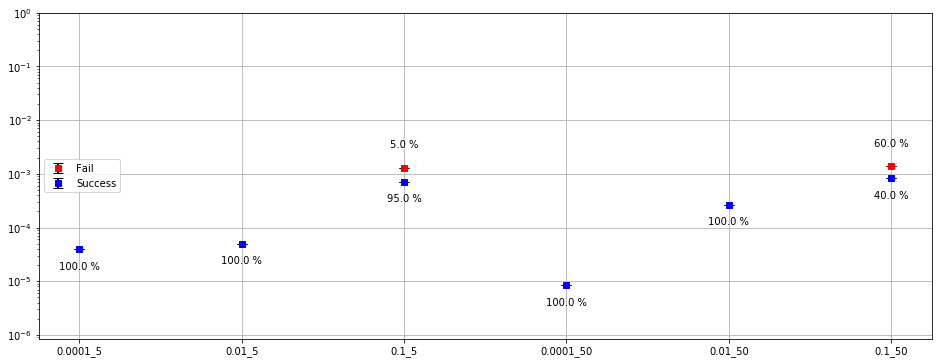

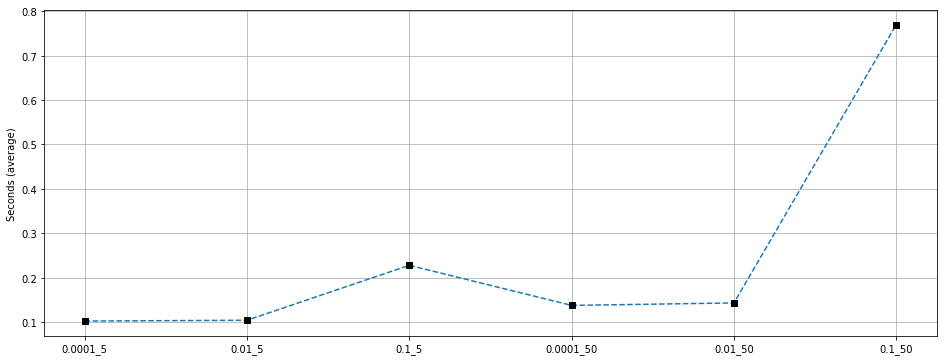

In [8]:
# Time to measure the performance of the defaults against swamps. 
trials = 20
display = True
    
results = tfx.disp.test_tensors(tensors_list, options_list, trials, display)

The blue marks of the top plot are the average of the successful tests, whereas the red marks indicates the failures. Each mark has a vertical bar corresponding to the variance of the errors, but since the variance is so low we can't see them. Above (red) and below (blue) the marks there are percentages showing how much successes and failures there are for each test tensor with its corresponding model. 

We can see that the defaults of Tensor Fox performs perfectly for almost every case, with the exception of the swamps with collinearity $c = 0.1$. The difficult in which Tensor Fox finds itself can be confirmed by the timing plots. All tests were conducted very fast, but the last one, which required a lot of effort. In fact, we may wonder if with more time Tensor Fox would be able to achieve a better performance in this last test. With this in mind, we repeat the tests with some different models.

,Tensor name,Maxiter,Tolerance,Initialization,Inner algorithm options,# Success,# Fail
0,0.0001_5,200,1.000000e-06,random,"[cg, 1, 1e-06]",20,0
1,0.01_5,200,1.000000e-06,random,"[cg, 1, 1e-06]",20,0
2,0.1_5,200,1.000000e-14,random,"[cg, 1, 1e-14]",20,0
3,0.0001_50,200,1.000000e-06,random,"[cg, 1, 1e-06]",20,0
4,0.01_50,200,1.000000e-06,random,"[cg, 1, 1e-06]",20,0
5,0.1_50,200,1.000000e-14,random,"[cg, 1, 1e-14]",20,0


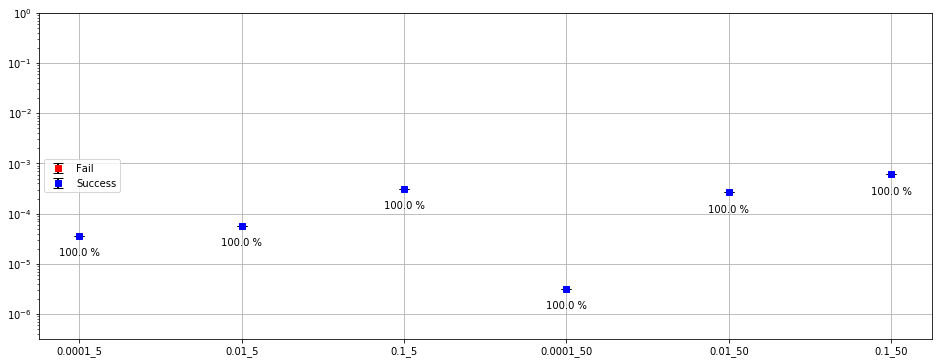

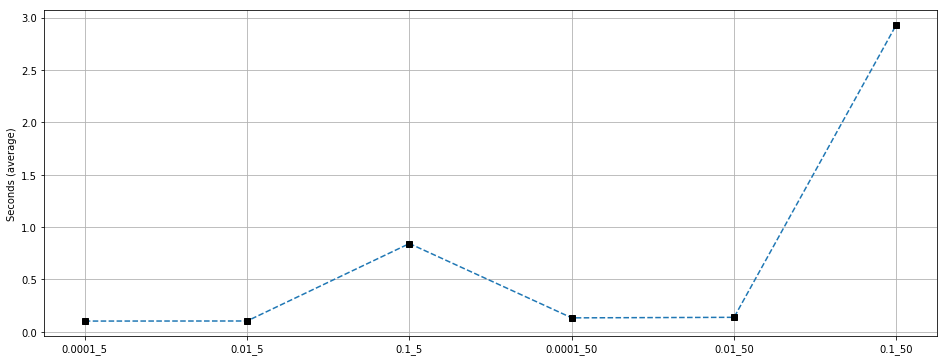

In [9]:
# Set False where it is already good, and decrease the tolerance where it is not good enough.
class options:
    tol = 1e-20
    
options_list = [False, False, options, False, False, options]
results = tfx.disp.test_tensors(tensors_list, options_list, trials, display)

Remember that the tolerance given is updated following the rule $\verb|tol| \leftarrow \verb|tol| \cdot mnp$. In this case the updated tolerance is $\verb|tol| = 10^{-20} \cdot 100^3 = 10^{-14}$, whereas the default one is $\verb|tol| = 10^{-12} \cdot 100^3 = 10^{-6}$. These are the values shown in the table. Also remember that the tolerance used in the inner algorithm (conjugate gradient in this case) is the same tolerance. In conclusion, the precision for swamps benefits from both decrease in tolerances. 